# Loss Functions in Scikit-learn

<!--<badge>--><a href="https://colab.research.google.com/github/kuennethgroup/ml_in_ms_st25/blob/main/06_ex/loss_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

## Objectives
- Understand different loss functions in scikit-learn
- Learn when to use specific loss functions
- Implement models with different loss functions
- Compare performance of models using various loss functions

## Introduction to Loss Functions

Loss functions (also called cost functions) measure how well a machine learning model performs by quantifying the difference between predicted values and actual values. The choice of loss function significantly impacts model behavior, especially when handling outliers and noisy data.

Common loss functions include:
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)
- Huber L
- Log Loss (for classification)
- Hinge Loss (for SVMs)


In [82]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.special import huber
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import seaborn as sns

# Set plot style

sns.set_palette("colorblind")

## Exploring Different Loss Functions

Let's first visualize some of the most common loss functions to understand their behavior, particularly how they respond to errors of different magnitudes.

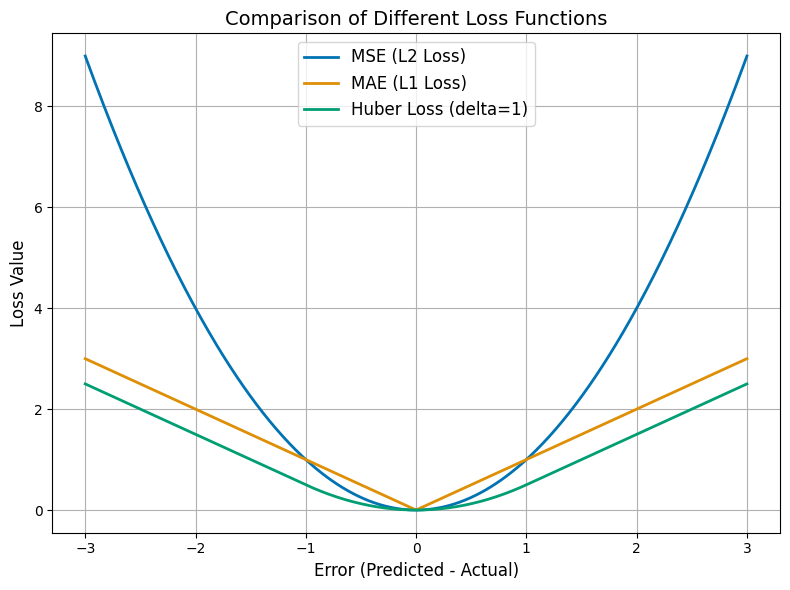

In [83]:
# Define a range of errors for visualization

errors = np.linspace(-3, 3, 500)  # y -y_hat

# Calculate different loss values
mse = errors**2  # Mean Squared Error (L2 Loss)
mae = np.abs(errors)  # Mean Absolute Error (L1 Loss)

# Huber loss
delta = 1
huber_l = huber(delta, errors)


# Plot the loss functions
plt.figure(figsize=(8, 6))
plt.plot(errors, mse, label="MSE (L2 Loss)", linewidth=2)
plt.plot(errors, mae, label="MAE (L1 Loss)", linewidth=2)
plt.plot(errors, huber_l, label=f"Huber Loss (delta={delta})", linewidth=2)

plt.grid(True)
plt.xlabel("Error (Predicted - Actual)", fontsize=12)
plt.ylabel("Loss Value", fontsize=12)
plt.title("Comparison of Different Loss Functions", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

### Key Observations:

1. **MSE (Mean Squared Error)**
   - Squares the errors, which heavily penalizes large errors --> sensitive to outliers
   - Mathematically convenient (differentiable everywhere)

2. **MAE (Mean Absolute Error)**
   - Linear increase with error magnitude
   - Not smooth and differentiable at zero (can create challenges for gradient-based optimization)

3. **Huber Loss**
   - Combines the best properties of MSE and MAE
   - Acts like MSE for small errors and MAE for large errors
   - Parameter δ (delta) controls the transition point
   - Robust to outliers while still being differentiable

## Working with Regression Models and Loss Functions

We'll use different regression models with various loss functions and evaluate their performance. We already have some data to work with:

- X: features (input data)
- y: target values (output data)
- X_train, X_test, y_train, y_test: data already split for training and testing

Let's first visualize our data to understand its characteristics.

,Feature_train,Target_train
count,800.000000,800.000000
mean,0.015704,0.188622
std,0.969084,17.996593
min,-2.696887,-50.357614
25%,-0.637475,-12.623885
50%,0.027602,-0.088099
75%,0.647944,12.010688
max,3.852731,57.900990


,Feature_test,Target_test
count,200.000000,200.000000
mean,0.033843,1.036580
std,1.021115,18.701349
min,-3.241267,-45.435166
25%,-0.655653,-11.606817
50%,-0.017720,0.743291
75%,0.649646,13.378818
max,3.078881,51.204136


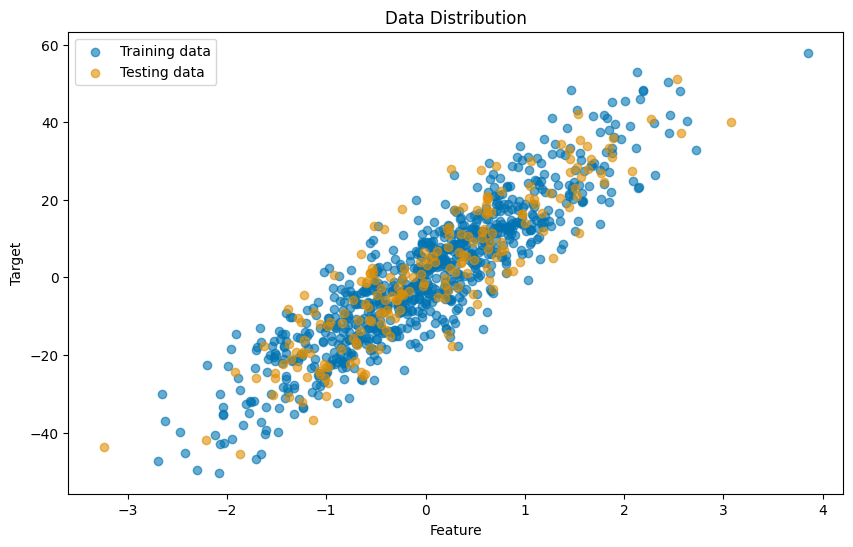

In [84]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import pandas as pd

X, y = make_regression(n_samples=1000, n_features=1, noise=8, random_state=42)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Let's examine our training data
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.6, label="Training data")
plt.scatter(X_test, y_test, alpha=0.6, label="Testing data")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.title("Data Distribution")
plt.legend()


df_train = pd.DataFrame(
    {
        "Feature_train": X_train.flatten(),
        "Target_train": y_train,
    }
)

df_test = pd.DataFrame(
    {
        "Feature_test": X_test.flatten(),
        "Target_test": y_test,
    }
)

display(df_train.describe())
display(df_test.describe())

## 1. Linear Regression with Different Loss Functions

Let's implement and compare different regression models, each optimizing for different loss functions:

1. **Standard Linear Regression**: Minimizes MSE
2. **Huber Regression**: Minimizes Huber loss (robust to outliers)
3. **Support Vector Regression (SVR)**: Uses ε-insensitive loss
4. **Random Forest Regression**: Ensemble method that typically minimizes MSE

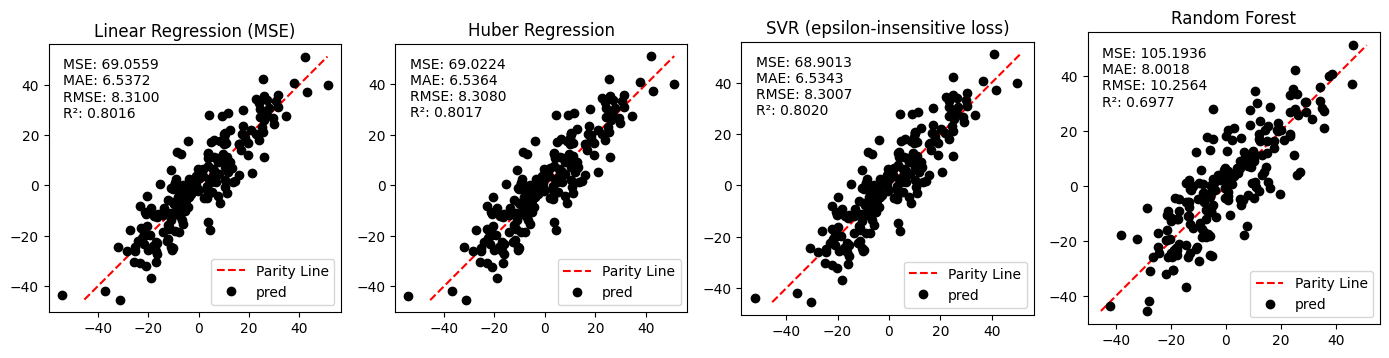

In [85]:
# Let's train different models
from cProfile import label


models = {
    "Linear Regression (MSE)": LinearRegression(),
    "Huber Regression": HuberRegressor(epsilon=1.35, alpha=0.0001, max_iter=100),
    "SVR (epsilon-insensitive loss)": SVR(kernel="linear", C=1.0, epsilon=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
}

# Dictionary to store fitted models and their predictions
fitted_models = {}
predictions = {}


fig, axes = plt.subplots(1, len(models), figsize=(14, 4))


# enforce same length of axes
for ax in axes:
    ax.set_aspect("equal")

# Train each model and make predictions
for ax, (name, model) in zip(axes, models.items()):
    # Train the model
    fitted_models[name] = model.fit(X_train.reshape(-1, 1), y_train)

    # Make predictions for the test set
    predictions[name] = fitted_models[name].predict(X_test.reshape(-1, 1))

    # plot parity line
    ax.plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        "r--",
        label="Parity Line",
    )
    # Plot predictions
    ax.plot(
        predictions[name],
        y_test,
        "ko",
        label=f"pred",
    )

    ax.legend()
    ax.set_title(name)

    # # Calculate metrics
    mse = mean_squared_error(y_test, predictions[name])
    mae = mean_absolute_error(y_test, predictions[name])
    r2_score_value = r2_score(y_test, predictions[name])

    ax.text(
        0.05,
        0.95,
        f"MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {np.sqrt(mse):.4f}\nR²: {r2_score_value:.4f}",
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
    )


fig.tight_layout()

## Visualizing Model Predictions

Let's visualize how each model fits the data and makes predictions.

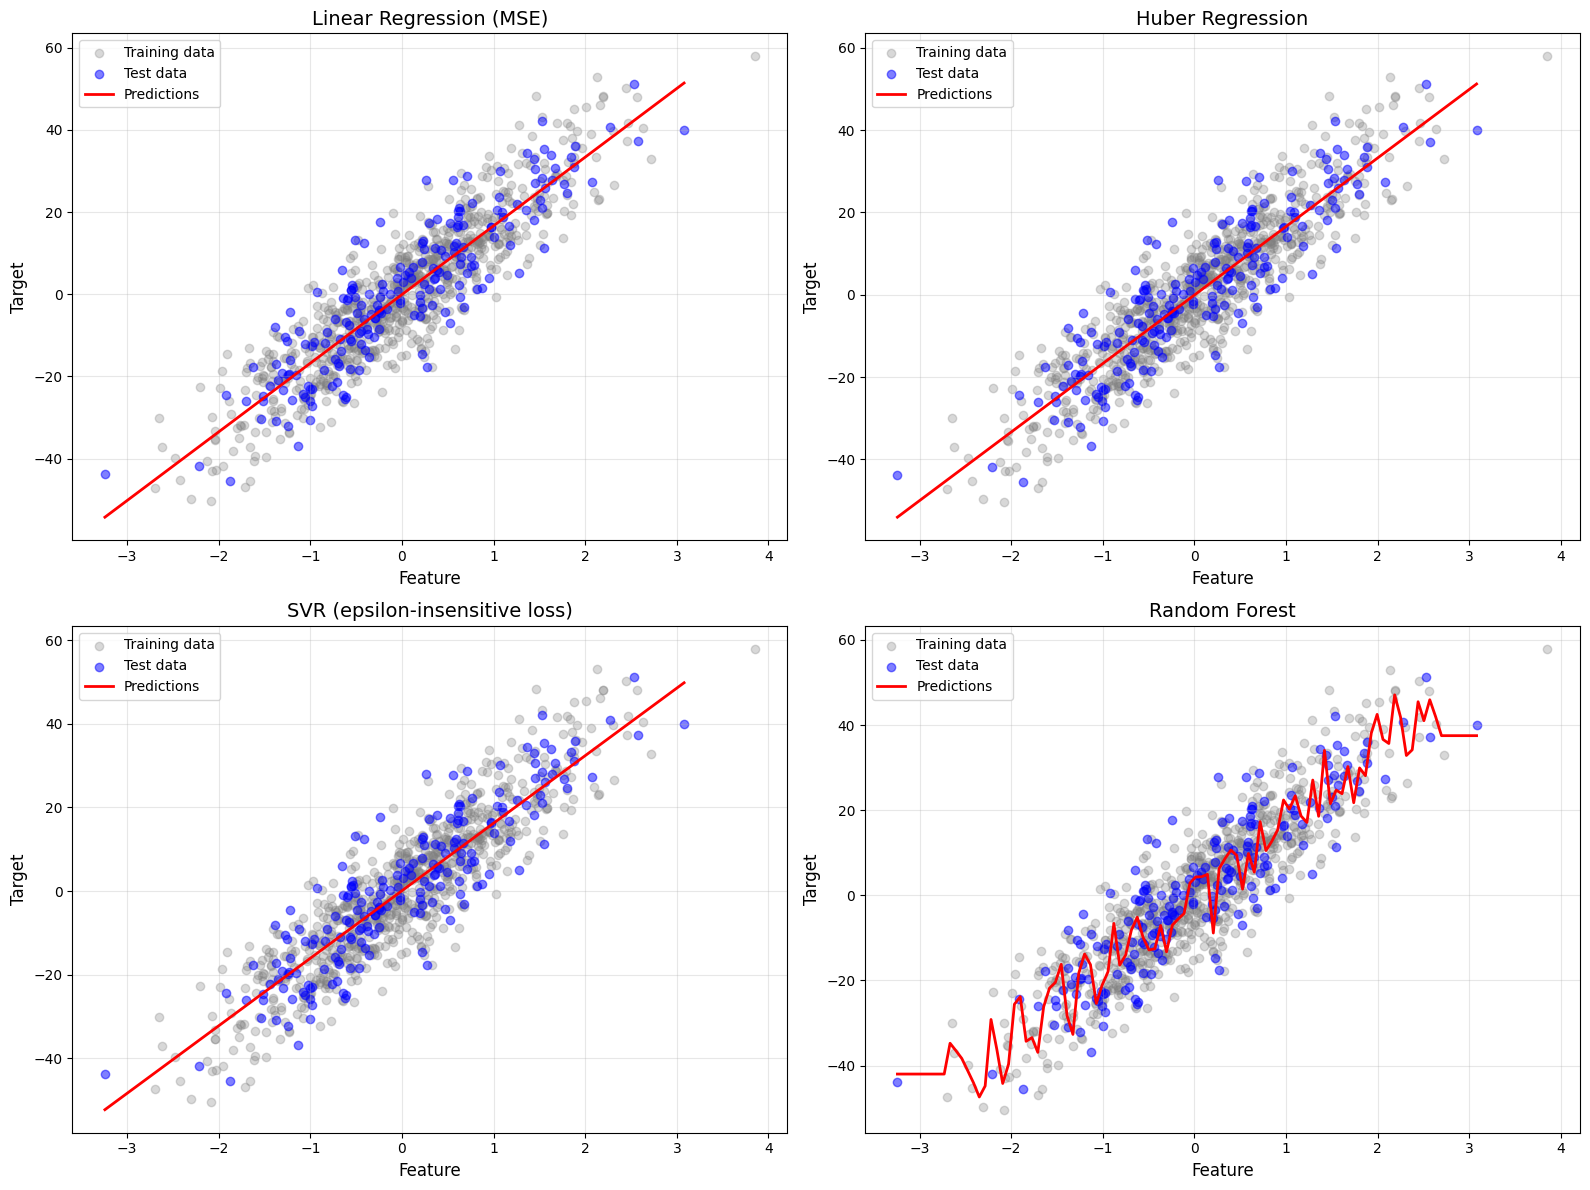

In [86]:
# Sort X_test and corresponding predictions for better visualization
sorted_indices = np.argsort(X_test)
X_test_sorted = X_test[sorted_indices]
y_test_sorted = y_test[sorted_indices]

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Plot each model's predictions
for i, (name, model) in enumerate(fitted_models.items()):
    ax = axes[i]

    # Create a denser grid for smoother curve visualization
    X_grid = np.linspace(X_test.min(), X_test.max(), 100)
    y_pred = model.predict(X_grid.reshape(-1, 1))

    # Plot training data, test data, and predictions
    ax.scatter(X_train, y_train, alpha=0.3, label="Training data", color="gray")
    ax.scatter(X_test, y_test, alpha=0.5, label="Test data", color="blue")
    ax.plot(X_grid, y_pred, "r-", linewidth=2, label="Predictions")

    ax.set_title(f"{name}", fontsize=14)
    ax.set_xlabel("Feature", fontsize=12)
    ax.set_ylabel("Target", fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary: Impact of Loss Functions

1. **Linear Regression (MSE)** works well when the relationship is linear and there are no outliers
2. **Random Forest** can capture non-linear relationships but may overfit to training data
3. **SVR** and **Huber Regression** perform similarly to linear regression on clean data

## Exercise

1. Increase and decrease the noise in the synthesized data. Observer how the model performance changes.

2. Try modifying the `epsilon` parameter in the Huber Regressor and observe how it affects model performance on data with outliers.
